In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objs as go
from scipy.optimize import minimize
from typing import List, Tuple
from functools import cache  
from IPython.display import display
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import date
from nsepy import get_history as gh
plt.style.use('fivethirtyeight')
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import  risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import plotting
from pypfopt import HRPOpt
from pypfopt.efficient_frontier import EfficientCVaR
import warnings
warnings.filterwarnings('ignore')

In [2]:
tickers = input('List stock ticker names and separate each with space')
tickers = tickers.upper()
tickers = tickers.split()
data = yf.download(tickers, period='2y', interval='1d')['Adj Close']
print(data)
#AAPL AMZN GOOG BRK-B JNJ JPM

List stock ticker names and separate each with spaceAAPL AMZN GOOG BRK-B JNJ JPM
[*********************100%***********************]  6 of 6 completed
                  AAPL        AMZN       BRK-B        GOOG         JNJ  \
Date                                                                     
2021-06-28  133.218872  172.194504  276.609985  126.819504  155.542191   
2021-06-29  134.750900  172.406998  276.209991  126.018501  155.551682   
2021-06-30  135.373642  172.007996  277.920013  125.316002  156.225006   
2021-07-01  135.680008  171.648499  280.170013  126.368500  157.381943   
2021-07-02  138.338867  175.548996  279.119995  128.718994  160.245865   
...                ...         ...         ...         ...         ...   
2023-06-20  185.009995  125.779999  338.670013  123.849998  164.130005   
2023-06-21  183.960007  124.830002  338.609985  121.260002  163.880005   
2023-06-22  187.000000  130.149994  336.959991  123.870003  165.619995   
2023-06-23  186.679993  129.330002  

In [3]:
# preprocessing to remove incorrect ticker's column and missing row
data=data.dropna(axis=1,how='all')
data=data.dropna(how='all')
print(data)

                  AAPL        AMZN       BRK-B        GOOG         JNJ  \
Date                                                                     
2021-06-28  133.218872  172.194504  276.609985  126.819504  155.542191   
2021-06-29  134.750900  172.406998  276.209991  126.018501  155.551682   
2021-06-30  135.373642  172.007996  277.920013  125.316002  156.225006   
2021-07-01  135.680008  171.648499  280.170013  126.368500  157.381943   
2021-07-02  138.338867  175.548996  279.119995  128.718994  160.245865   
...                ...         ...         ...         ...         ...   
2023-06-20  185.009995  125.779999  338.670013  123.849998  164.130005   
2023-06-21  183.960007  124.830002  338.609985  121.260002  163.880005   
2023-06-22  187.000000  130.149994  336.959991  123.870003  165.619995   
2023-06-23  186.679993  129.330002  335.250000  123.019997  165.479996   
2023-06-26  185.270004  127.330002  334.119995  119.089996  163.630005   

                   JPM  
Date        

In [4]:
# calculating expected annual return and annualized sample covariance matrix of daily assets returns

mean = expected_returns.mean_historical_return(data)
mean

AAPL     0.180453
AMZN    -0.140861
BRK-B    0.099671
GOOG    -0.031136
JNJ      0.025825
JPM     -0.022502
dtype: float64

In [5]:
S = risk_models.sample_cov(data) # for sample covariance matrix
S

,AAPL,AMZN,BRK-B,GOOG,JNJ,JPM
AAPL,0.088356,0.079928,0.033708,0.072096,0.014899,0.036342
AMZN,0.079928,0.172873,0.036634,0.097438,0.012177,0.042714
BRK-B,0.033708,0.036634,0.035937,0.033451,0.013792,0.035840
GOOG,0.072096,0.097438,0.033451,0.114484,0.012505,0.035474
JNJ,0.014899,0.012177,0.013792,0.012505,0.025775,0.012018
JPM,0.036342,0.042714,0.035840,0.035474,0.012018,0.070692


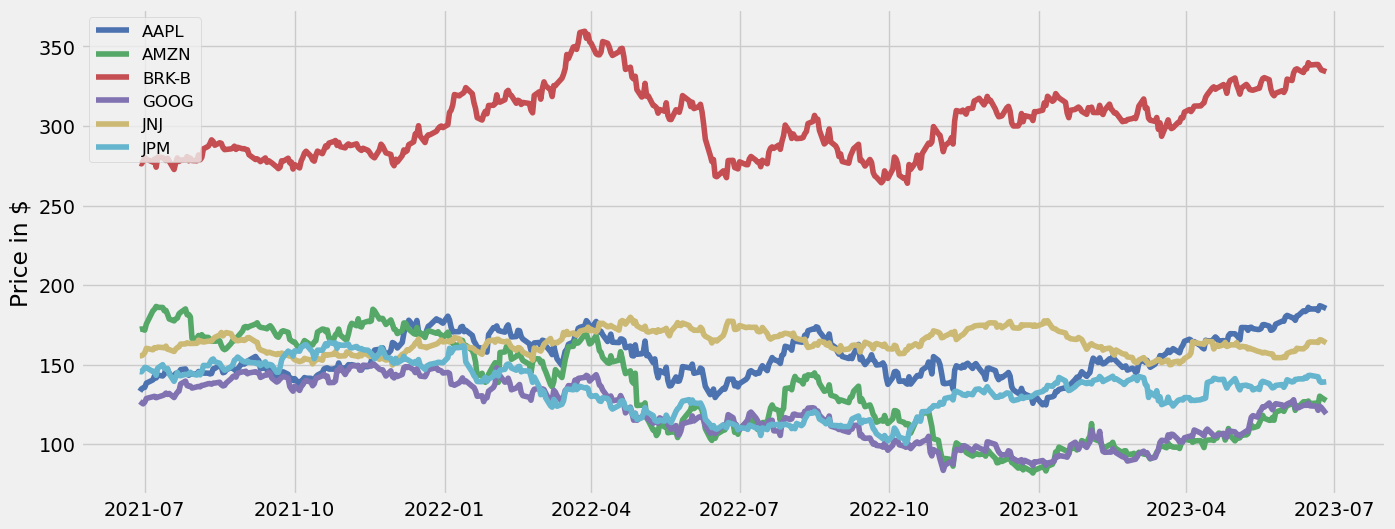

In [6]:
plt.figure(figsize=(15, 6))
for i in range(data.shape[1]):
    plt.plot(data.iloc[:,i], label=data.columns.values[i])
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Price in $')
plt.show()

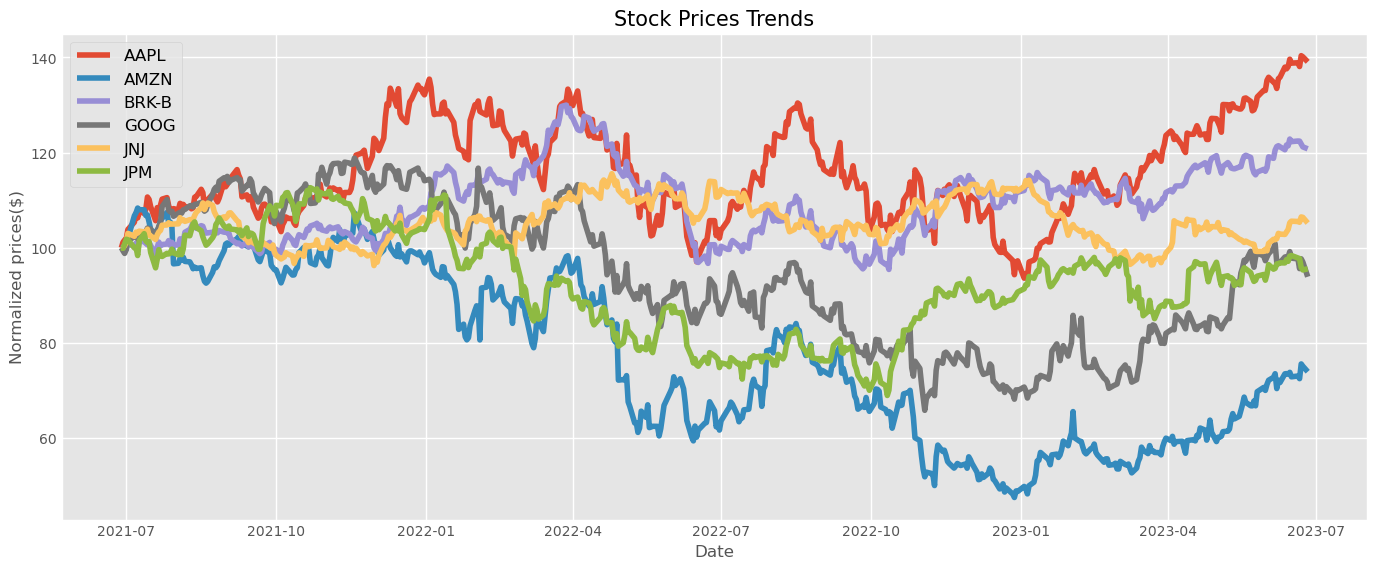

In [43]:
# Normalized price
data_nor = data.divide(data.iloc[0] / 100)

plt.figure(figsize=(15, 6))
for i in range(data_nor.shape[1]):
    plt.plot(data_nor.iloc[:,i], label=data_nor.columns.values[i])
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Normalized prices($)')
plt.title('Stock Prices Trends', fontsize=15)
plt.xlabel('Date')
plt.show()

Covariance between daily simple returns of stocks in your portfolio


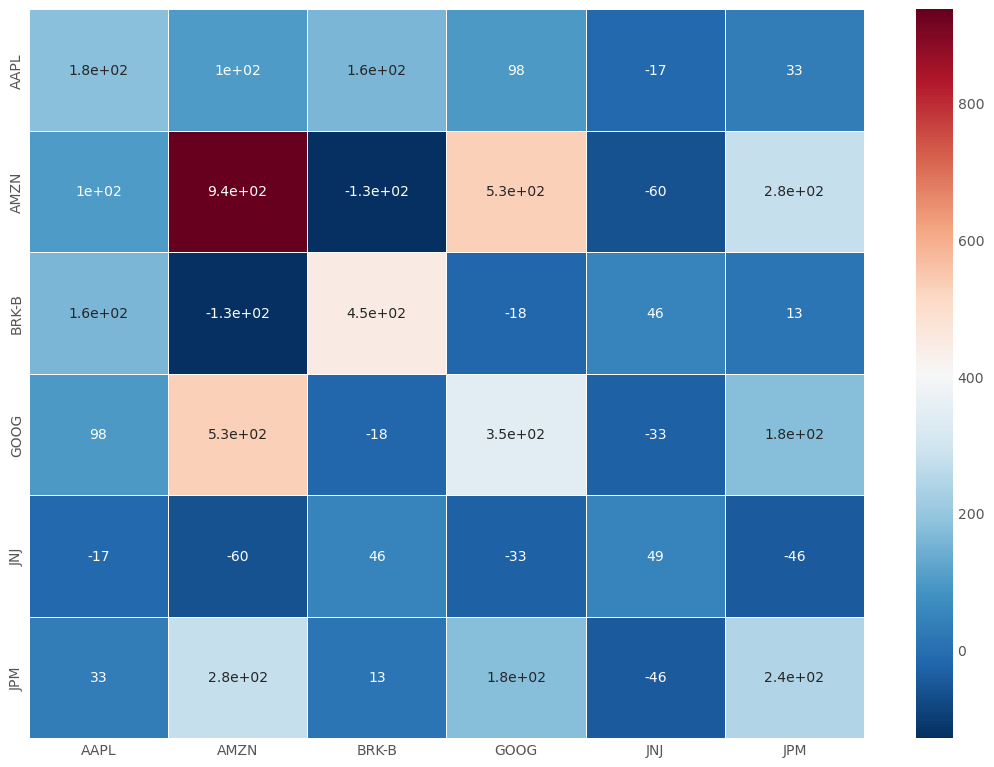

In [46]:
plt.style.use('ggplot')
fig = plt.figure()
sb.heatmap(S,xticklabels=S.columns, yticklabels=S.columns,
cmap='RdBu_r', annot=True, linewidth=0.5)
print('Covariance between daily simple returns of stocks in your portfolio')
plt.show(fig)

EfficientFrontier portfolio

Portfolio Allocation


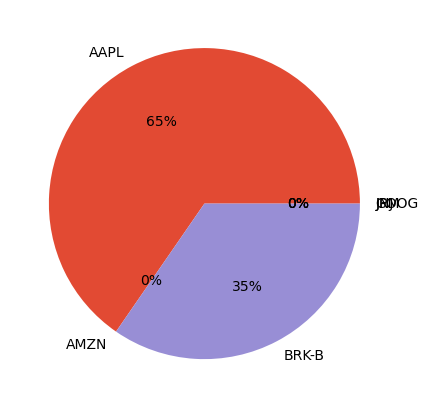

In [9]:
ef = EfficientFrontier(mean,S)
weights = ef.max_sharpe() #for maximizing the Sharpe ratio #Optimization
cleaned_weights = ef.clean_weights() #to clean the raw weights
# Get the Keys and store them in a list
labels = list(cleaned_weights.keys())
# Get the Values and store them in a list
values = list(cleaned_weights.values())
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.0f%%')
print('Portfolio Allocation')
plt.show(fig)

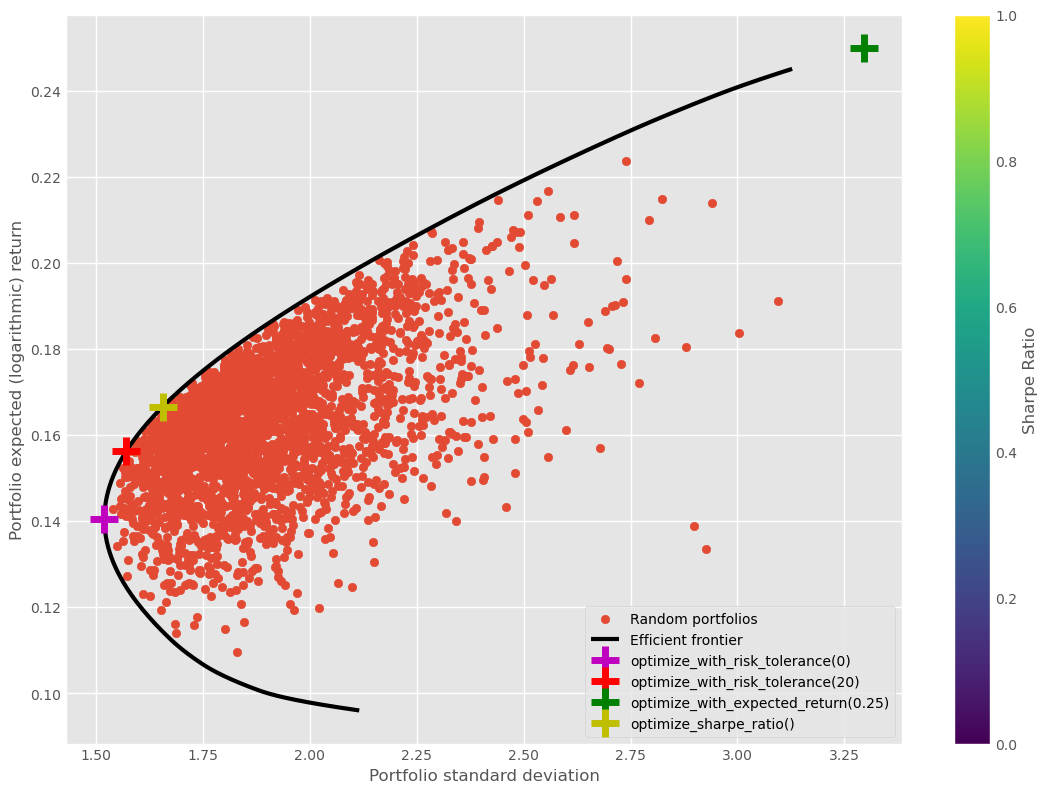

In [10]:
rcParams['figure.figsize'] = 12, 9

TREASURY_BILL_RATE = 0.11 
TRADING_DAYS_PER_YEAR = 250


# Needed for type hinting
class Asset:
  pass


def get_log_period_returns(price_history: pd.DataFrame):
  close = price_history['Close'].values  
  return np.log(close[1:] / close[:-1]).reshape(-1, 1)


# daily_price_history has to at least have a column, called 'Close'
class Asset:
  def __init__(self, name: str, daily_price_history: pd.DataFrame):
    self.name = name
    self.daily_returns = get_log_period_returns(daily_price_history)
    self.expected_daily_return = np.mean(self.daily_returns)
  
  @property
  def expected_return(self):
    return TRADING_DAYS_PER_YEAR * self.expected_daily_return

  def __repr__(self):
    return f'<Asset name={self.name}, expected return={self.expected_return}>'

  @staticmethod
  @cache
  def covariance_matrix(assets: Tuple[Asset]):  # tuple for hashing in the cache
    product_expectation = np.zeros((len(assets), len(assets)))
    for i in range(len(assets)):
      for j in range(len(assets)):
        if i == j:
          product_expectation[i][j] = np.mean(assets[i].daily_returns * assets[j].daily_returns)
        else:
          product_expectation[i][j] = np.mean(assets[i].daily_returns @ assets[j].daily_returns.T)
    
    product_expectation *= (TRADING_DAYS_PER_YEAR - 1) ** 2

    expected_returns = np.array([asset.expected_return for asset in assets]).reshape(-1, 1)
    product_of_expectations = expected_returns @ expected_returns.T

    return product_expectation - product_of_expectations


def random_weights(weight_count):
    weights = np.random.random((weight_count, 1))
    weights /= np.sum(weights)
    return weights.reshape(-1, 1)


class Portfolio:
  def __init__(self, assets: Tuple[Asset]):
    self.assets = assets
    self.asset_expected_returns = np.array([asset.expected_return for asset in assets]).reshape(-1, 1)
    self.covariance_matrix = Asset.covariance_matrix(assets)
    self.weights = random_weights(len(assets))
    
  def unsafe_optimize_with_risk_tolerance(self, risk_tolerance: float):
    res = minimize(
      lambda w: self._variance(w) - risk_tolerance * self._expected_return(w),
      random_weights(self.weights.size),
      constraints=[
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
      ],
      bounds=[(0., 1.) for i in range(self.weights.size)]
    )

    assert res.success, f'Optimization failed: {res.message}'
    self.weights = res.x.reshape(-1, 1)
  
  def optimize_with_risk_tolerance(self, risk_tolerance: float):
    assert risk_tolerance >= 0.
    return self.unsafe_optimize_with_risk_tolerance(risk_tolerance)
  
  def optimize_with_expected_return(self, expected_portfolio_return: float):
    res = minimize(
      lambda w: self._variance(w),
      random_weights(self.weights.size),
      constraints=[
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
        {'type': 'eq', 'fun': lambda w: self._expected_return(w) - expected_portfolio_return},
      ],
      bounds=[(0., 1.) for i in range(self.weights.size)]
    )

    assert res.success, f'Optimization failed: {res.message}'
    self.weights = res.x.reshape(-1, 1)

  def optimize_sharpe_ratio(self):
    # Maximize Sharpe ratio = minimize minus Sharpe ratio
    res = minimize(
      lambda w: -(self._expected_return(w) - TREASURY_BILL_RATE / 100) / np.sqrt(self._variance(w)),
      random_weights(self.weights.size),
      constraints=[
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
      ],
      bounds=[(0., 1.) for i in range(self.weights.size)]
    )

    assert res.success, f'Optimization failed: {res.message}'
    self.weights = res.x.reshape(-1, 1)

  def _expected_return(self, w):
    return (self.asset_expected_returns.T @ w.reshape(-1, 1))[0][0]
  
  def _variance(self, w):
    return (w.reshape(-1, 1).T @ self.covariance_matrix @ w.reshape(-1, 1))[0][0]

  @property
  def expected_return(self):
    return self._expected_return(self.weights)
  
  @property
  def variance(self):
    return self._variance(self.weights)

  def __repr__(self):
    return f'<Portfolio assets={[asset.name for asset in self.assets]}, expected return={self.expected_return}, variance={self.variance}>'


def yf_retrieve_data(tickers: List[str]):
  dataframes = []

  for ticker_name in tickers:
    ticker = yf.Ticker(ticker_name)
    history = ticker.history(period='10y')

    if history.isnull().any(axis=1).iloc[0]:  # the first row can have NaNs
      history = history.iloc[1:]
  
    assert not history.isnull().any(axis=None), f'history has NaNs in {ticker_name}'
    dataframes.append(history)
  
  return dataframes


#stocks = input('Enter stock ticker names with space')
#stocks =n.split()

#stocks = ['AAPL', 'AMZN', 'GOOG', 'BRK-B', 'JNJ', 'JPM']
daily_dataframes = yf_retrieve_data(tickers)
assets = tuple([Asset(name, daily_df) for name, daily_df in zip(tickers, daily_dataframes)])

X = []
y = []

# Drawing random portfolios
for i in range(3000):
  portfolio = Portfolio(assets)
  X.append(np.sqrt(portfolio.variance))
  y.append(portfolio.expected_return)

plt.scatter(X, y, label='Random portfolios')

# Drawing the efficient frontier
X = []
y = []
for rt in np.linspace(-300, 200, 1000):
  portfolio.unsafe_optimize_with_risk_tolerance(rt)
  X.append(np.sqrt(portfolio.variance))
  y.append(portfolio.expected_return)

plt.plot(X, y, 'k', linewidth=3, label='Efficient frontier')

# Drawing optimized portfolios
portfolio.optimize_with_risk_tolerance(0)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'm+', markeredgewidth=5, markersize=20, label='optimize_with_risk_tolerance(0)')

portfolio.optimize_with_risk_tolerance(20)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'r+', markeredgewidth=5, markersize=20, label='optimize_with_risk_tolerance(20)')

portfolio.optimize_with_expected_return(0.25)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'g+', markeredgewidth=5, markersize=20, label='optimize_with_expected_return(0.25)')

portfolio.optimize_sharpe_ratio()
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'y+', markeredgewidth=5, markersize=20, label='optimize_sharpe_ratio()')

plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Portfolio standard deviation')
plt.ylabel('Portfolio expected (logarithmic) return')
plt.legend(loc='lower right')
plt.show()


In [11]:
print(dict(cleaned_weights))

{'AAPL': 0.65384, 'AMZN': 0.0, 'BRK-B': 0.34616, 'GOOG': 0.0, 'JNJ': 0.0, 'JPM': 0.0}


In [12]:
ef.portfolio_performance(verbose=True)

Expected annual return: 15.2%
Annual volatility: 23.9%
Sharpe Ratio: 0.55


(0.15248964750842148, 0.23945283859045388, 0.5533016367161302)

In [13]:
latest_prices = get_latest_prices(data)

total_portfolio_value = float(input("Enter the amount you want to invest: "))

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value)

allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Enter the amount you want to invest: 10000
Discrete allocation: {'AAPL': 35, 'BRK-B': 10}
Funds remaining: $174.35


 Hierarchical Risk Parity (HRP)

In [14]:
returns = data.pct_change().dropna()
hrp = HRPOpt(returns)
hrp_weights = hrp.optimize()
hrp.portfolio_performance(verbose=True)
print(dict(hrp_weights))

Expected annual return: 5.7%
Annual volatility: 15.8%
Sharpe Ratio: 0.23
{'AAPL': 0.07736523253648446, 'AMZN': 0.0676503506077298, 'BRK-B': 0.20710869283831887, 'GOOG': 0.05970884492018623, 'JNJ': 0.48287989531790837, 'JPM': 0.10528698377937225}


In [15]:
da_hrp = DiscreteAllocation(hrp_weights, latest_prices, total_portfolio_value)

allocation, leftover = da_hrp.greedy_portfolio()
print("Discrete allocation (HRP):", allocation)
print("Funds remaining (HRP): ${:.2f}".format(leftover))

Discrete allocation (HRP): {'JNJ': 29, 'BRK-B': 6, 'JPM': 8, 'AAPL': 4, 'AMZN': 6, 'GOOG': 5}
Funds remaining (HRP): $35.98


 Mean Conditional Value at Risk (mCVAR)

In [16]:
S = data.cov()
ef_cvar = EfficientCVaR(mean, S)
cvar_weights = ef_cvar.min_cvar()

cleaned_weights = ef_cvar.clean_weights()
print(dict(cleaned_weights))

{'AAPL': 0.0, 'AMZN': 0.13413, 'BRK-B': 0.59634, 'GOOG': 0.0, 'JNJ': 0.26952, 'JPM': 0.0}


In [17]:
da_cvar = DiscreteAllocation(cvar_weights, latest_prices, total_portfolio_value)

allocation, leftover = da_cvar.greedy_portfolio()
print("Discrete allocation (CVAR):", allocation)
print("Funds remaining (CVAR): ${:.2f}".format(leftover))

Discrete allocation (CVAR): {'BRK-B': 18, 'JNJ': 16, 'AMZN': 10}
Funds remaining (CVAR): $94.46


## Stock Price Prediction

In [18]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
import keras
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import pydot
import graphviz
from keras.models import load_model
from keras.utils.vis_utils import plot_model 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
 


In [19]:
ticker = input("Enter tickers: ")
ticker = ticker.upper()
ticker = ticker.split()
df = yf.download(ticker, period='10y', interval='1d')
df = pd.DataFrame(df)
df

Enter tickers: AAPL
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-06-27,14.258929,14.335357,14.055000,14.063571,12.209949,337246000
2013-06-28,13.977143,14.295357,13.888214,14.161786,12.295217,578516400
2013-07-01,14.381786,14.723929,14.329286,14.615000,12.688700,391053600
2013-07-02,14.641429,15.058214,14.623929,14.946071,12.976138,469865200
2013-07-03,15.030714,15.106429,14.908929,15.028571,13.047760,240928800
...,...,...,...,...,...,...
2023-06-20,184.410004,186.100006,184.410004,185.009995,185.009995,49799100
2023-06-21,184.899994,185.410004,182.589996,183.960007,183.960007,49515700
2023-06-22,183.740005,187.050003,183.669998,187.000000,187.000000,51245300


In [20]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,69.257951,70.038274,68.524756,69.316591,67.456058,1.513875e+08
std,51.782297,52.440800,51.173853,51.841287,52.349468,9.800529e+07
min,13.977143,14.295357,13.888214,14.063571,12.209949,3.519590e+07
25%,28.199375,28.503124,27.913126,28.227499,25.826185,8.671128e+07
50%,43.777500,44.112501,43.567501,43.822500,41.959873,1.212406e+08
75%,123.202503,124.692499,121.214998,122.955002,121.287163,1.858661e+08
max,186.830002,188.050003,185.229996,187.000000,187.000000,1.065523e+09


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2013-06-27 to 2023-06-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2516 non-null   float64
 1   High       2516 non-null   float64
 2   Low        2516 non-null   float64
 3   Close      2516 non-null   float64
 4   Adj Close  2516 non-null   float64
 5   Volume     2516 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


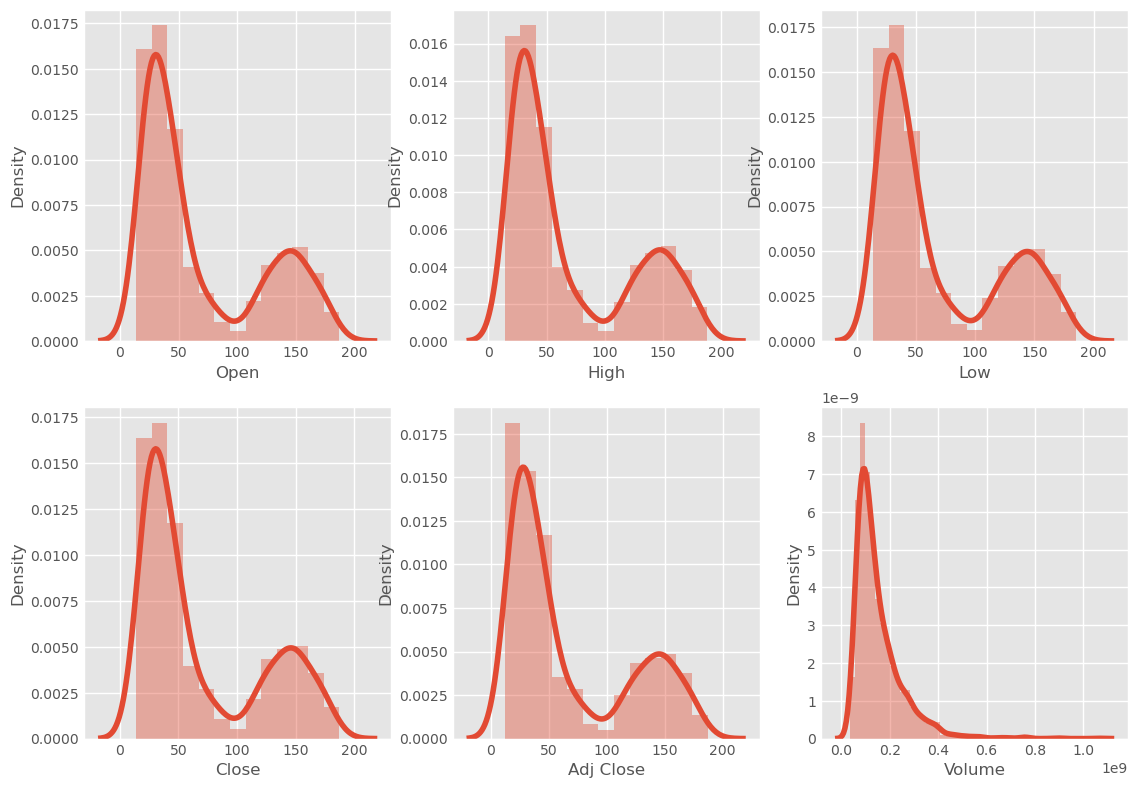

In [22]:
for i, col in enumerate(df):
  plt.subplot(2,3,i+1)
  sb.distplot(df[col])
plt.show()

In [23]:
#Print the shape of Dataframe  and Check for Null Values
print('Dataframe Shape: ',df.shape)

Dataframe Shape:  (2516, 6)


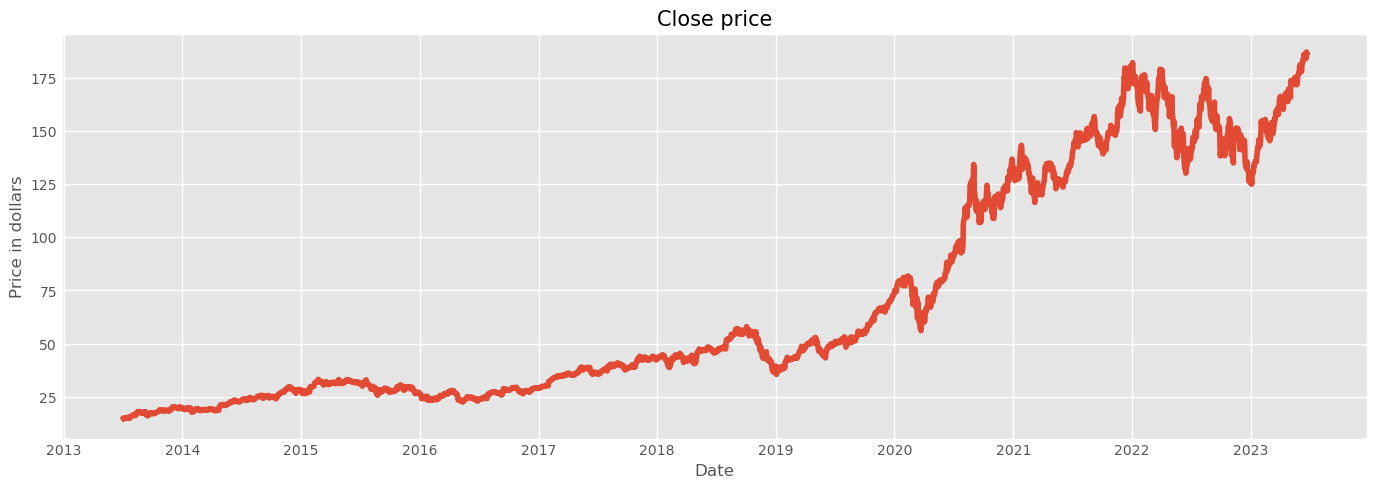

In [24]:
#The adjusted closing price is a more accurate indicator of stock value since it starts where the closing price finishes
plt.figure(figsize=(15,5))
plt.plot(df['Close'])
plt.title('Close price', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Price in dollars')
plt.show()

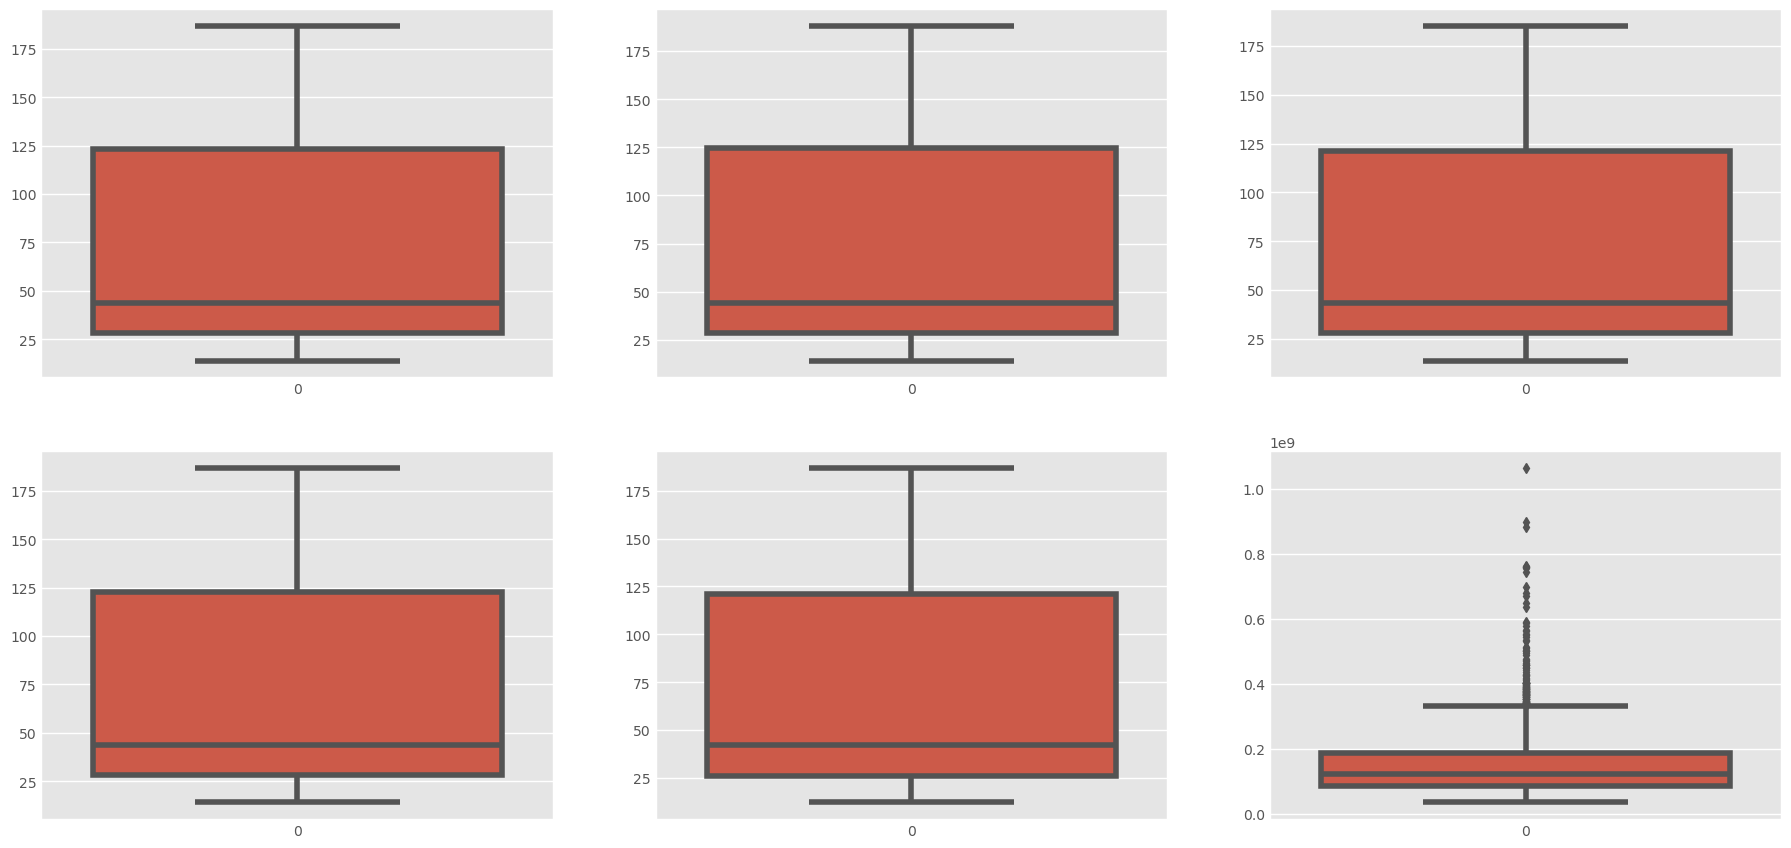

In [25]:

plt.subplots(figsize=(20,10))
plt.title('Close price', fontsize=15)
for i, col in enumerate(df):
  plt.subplot(2,3,i+1)
  sb.boxplot(df[col])
plt.show()

 Models development and evaluation

In [26]:
df['open-close']  = df['Open'] - df['Close']
df['low-high']  = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

In [27]:
#Data Splitting and Normalization
features = df[['open-close', 'low-high']]
target = df['target']
 
scaler = StandardScaler()
features = scaler.fit_transform(features)
 
X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=2022)
print(X_train.shape, X_valid.shape)

(2264, 2) (252, 2)


Regression model and Support Vector Machine

In [28]:
models = [LogisticRegression(), SVC(
  kernel='poly', probability=True)]
 
for i in range(2):
  models[i].fit(X_train, Y_train)
 
  print(f'{models[i]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(
    Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(
    Y_valid, models[i].predict_proba(X_valid)[:,1]))
  print()

LogisticRegression() : 
Training Accuracy :  0.5211501888116103
Validation Accuracy :  0.4969717998864425

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.48836359878139585
Validation Accuracy :  0.5195571257333922



LSTM

In [29]:
#Set Target Variable
output_var = pd.DataFrame(df['Close'])
#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

In [30]:
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
2013-06-27,0.001630,0.000230,0.000973,0.293159
2013-06-28,0.000000,0.000000,0.000000,0.527328
2013-07-01,0.002341,0.002467,0.002574,0.345383
2013-07-02,0.003843,0.004390,0.004294,0.421875
2013-07-03,0.006095,0.004668,0.005957,0.199677


In [31]:
#Creating a Training Set and a Test Set for Stock Market Prediction

#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [32]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [33]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [34]:
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
286/286 [==============================] - 2s 3ms/step - loss: 5141.7441
Epoch 2/100
286/286 [==============================] - 1s 2ms/step - loss: 4163.2979
Epoch 3/100
286/286 [==============================] - 1s 2ms/step - loss: 3036.8010
Epoch 4/100
286/286 [==============================] - 1s 2ms/step - loss: 1957.4196
Epoch 5/100
286/286 [==============================] - 1s 2ms/step - loss: 1138.7184
Epoch 6/100
286/286 [==============================] - 1s 2ms/step - loss: 641.8358
Epoch 7/100
286/286 [==============================] - 1s 2ms/step - loss: 392.3282
Epoch 8/100
286/286 [==============================] - 1s 2ms/step - loss: 269.7263
Epoch 9/100
286/286 [==============================] - 0s 2ms/step - loss: 191.4060
Epoch 10/100
286/286 [==============================] - 1s 2ms/step - loss: 124.9514
Epoch 11/100
286/286 [==============================] - 1s 2ms/step - loss: 71.5835
Epoch 12/100
286/286 [==============================] - 1s 2ms/step - 

286/286 [==============================] - 1s 2ms/step - loss: 0.8977
Epoch 100/100
286/286 [==============================] - 1s 2ms/step - loss: 0.8971


Since lstm gives the highest accuracy, we will use it for the prediction

In [56]:
#LSTM Prediction
y_pred= lstm.predict(X_test)
print(y_pred[-1])


8/8 [==============================] - 5s 4ms/step
[182.77444]


In [ ]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

#https://www.analyticsvidhya.com/blog/2021/10/machine-learning-for-stock-market-prediction-with-step-by-step-implementation/

# Deployment

In [49]:
import pickle


In [50]:
pickle.dump(lstm, open('lstm.pkl', 'wb'))

In [57]:
pickled_model = (pickle.load(open('lstm.pkl', 'rb')))

FileNotFoundError: [Errno 2] No such file or directory: 'lstm.pkl'

In [55]:
pickled_model.predict(X_test)[-1]

8/8 [==============================] - 8s 4ms/step


array([182.77444], dtype=float32)